In [1]:
import joblib
import os
import numpy as np
import pandas as pd

# Load saved artifacts
MODEL_DIR = os.path.join(os.getcwd(), 'public', 'data', 'waterlogging_model')
kmeans = joblib.load(os.path.join(MODEL_DIR, 'kmeans.pkl'))
scaler = joblib.load(os.path.join(MODEL_DIR, 'scaler.pkl'))
cluster_dispersion = joblib.load(os.path.join(MODEL_DIR, 'cluster_dispersion.pkl'))

centroids = kmeans.cluster_centers_

print(f"✓ Loaded artifacts from {MODEL_DIR}")
print(f"✓ Number of clusters: {len(centroids)}")
print(f"✓ Cluster dispersions: {cluster_dispersion}")

✓ Loaded artifacts from d:\hack4delhi\water-logging-with-cordds\public\data\waterlogging_model
✓ Number of clusters: 4
✓ Cluster dispersions: [0.11356942 0.         0.08903447 0.11956747]


In [7]:
# Define risk zones based on distance to nearest cluster
def get_risk_zone(latitude, longitude, high_threshold=0.5, medium_threshold=1.5):
    """
    Determine risk zone based on distance to nearest cluster.
    
    Parameters:
    - latitude, longitude: float coordinates
    - high_threshold: distance threshold for HIGH RISK (inside cluster, default 0.5)
    - medium_threshold: distance threshold for MEDIUM RISK (near cluster, default 1.5)
    
    Returns:
    - risk_zone: str ('HIGH RISK ZONE', 'MEDIUM RISK ZONE', 'LOW RISK ZONE')
    - nearest_cluster_id: int (cluster index)
    - distance_to_nearest: float (distance to nearest cluster)
    """
    # Scale coordinates
    coords = np.array([[latitude, longitude]])
    coords_scaled = scaler.transform(coords)[0]
    
    # Calculate distances to all cluster centroids
    distances = np.linalg.norm(centroids - coords_scaled, axis=1)
    
    # Find nearest cluster
    nearest_cluster_id = int(np.argmin(distances))
    distance_to_nearest = float(distances[nearest_cluster_id])
    
    # Determine risk zone
    if distance_to_nearest <= high_threshold:
        risk_zone = "HIGH RISK ZONE"
    elif distance_to_nearest <= medium_threshold:
        risk_zone = "MEDIUM RISK ZONE"
    else:
        risk_zone = "LOW RISK ZONE"
    
    return risk_zone, nearest_cluster_id, distance_to_nearest

print("✓ Risk zone function defined")
print(f"  - HIGH RISK: distance <= 0.5 (inside cluster)")
print(f"  - MEDIUM RISK: 0.5 < distance <= 1.5 (near cluster)")
print(f"  - LOW RISK: distance > 1.5 (far from cluster)")

✓ Risk zone function defined
  - HIGH RISK: distance <= 0.5 (inside cluster)
  - MEDIUM RISK: 0.5 < distance <= 1.5 (near cluster)
  - LOW RISK: distance > 1.5 (far from cluster)


In [3]:
# Test Example 1: Single coordinate
print("=== TEST EXAMPLE 1 ===")
lat, lon = 28.636, 77.228
risk_zone, cluster_id, distance = get_risk_zone(lat, lon)

print(f"\nCoordinates: ({lat:.6f}, {lon:.6f})")
print(f"Nearest Cluster: {cluster_id}")
print(f"Distance to Nearest Cluster: {distance:.4f}")
print(f"\n>>> {risk_zone} <<<")
print(f"    (Cluster dispersion: {cluster_dispersion[cluster_id]:.4f})")

=== TEST EXAMPLE 1 ===

Coordinates: (28.636000, 77.228000)
Nearest Cluster: 2
Distance to Nearest Cluster: 0.1079

>>> HIGH RISK ZONE <<<
    (Cluster dispersion: 0.0890)


In [11]:
# Test Example 2: Multiple coordinates
print("=== TEST EXAMPLE 2: Multiple Locations ===")

test_locations = [
    (28.5747046, 77.119109, "Kirby Place Drain"),
    (28.602922, 77.2019172, "Mother Teresa Crescent Road"),
    (28.6225, 77.2142, "Ashoka Road"),
    (28.5747, 77.1191, "Dwarka Road"),
    (28.6700, 77.2800, "GT Road"),
]

results = []
for lat, lon, name in test_locations:
    risk_zone, cluster_id, distance = get_risk_zone(lat, lon)
    results.append({
        'Location': name,
        'Latitude': lat,
        'Longitude': lon,
        'Nearest_Cluster': cluster_id,
        'Distance_to_Cluster': distance,
        'Risk_Zone': risk_zone
    })
    print(f"\n{name}")
    print(f"  Coordinates: ({lat:.6f}, {lon:.6f})")
    print(f"  Nearest Cluster: {cluster_id} (dispersion: {cluster_dispersion[cluster_id]:.4f})")
    print(f"  Distance: {distance:.4f}")
    print(f"  >>> {risk_zone} <<<")

# Convert to DataFrame for easy viewing
df_results = pd.DataFrame(results)
print("\n=== SUMMARY TABLE ===")
print(df_results.to_string(index=False))

=== TEST EXAMPLE 2: Multiple Locations ===

Kirby Place Drain
  Coordinates: (28.574705, 77.119109)
  Nearest Cluster: 0 (dispersion: 0.1136)
  Distance: 0.0551
  >>> HIGH RISK ZONE <<<

Mother Teresa Crescent Road
  Coordinates: (28.602922, 77.201917)
  Nearest Cluster: 2 (dispersion: 0.0890)
  Distance: 0.0298
  >>> HIGH RISK ZONE <<<

Ashoka Road
  Coordinates: (28.622500, 77.214200)
  Nearest Cluster: 2 (dispersion: 0.0890)
  Distance: 0.0498
  >>> HIGH RISK ZONE <<<

Dwarka Road
  Coordinates: (28.574700, 77.119100)
  Nearest Cluster: 0 (dispersion: 0.1136)
  Distance: 0.0551
  >>> HIGH RISK ZONE <<<

GT Road
  Coordinates: (28.670000, 77.280000)
  Nearest Cluster: 3 (dispersion: 0.1196)
  Distance: 0.1017
  >>> MEDIUM RISK ZONE <<<

=== SUMMARY TABLE ===
                   Location  Latitude  Longitude  Nearest_Cluster  Distance_to_Cluster        Risk_Zone
          Kirby Place Drain 28.574705  77.119109                0             0.055116   HIGH RISK ZONE
Mother Teresa Crescen

In [10]:
# RECALIBRATE: Analyze actual point-to-centroid distances from training data
print("=== RECALIBRATING RISK THRESHOLDS ===")

# Reload balanced training data to analyze realistic distances
data = pd.read_csv('waterlogging_final.csv')
X = data[['latitude', 'longitude']].values
X_scaled = scaler.transform(X)

# Compute distances to nearest cluster for all training points
point_distances = []
for point in X_scaled:
    distances = np.linalg.norm(centroids - point, axis=1)
    nearest_dist = np.min(distances)
    point_distances.append(nearest_dist)

point_distances = np.array(point_distances)

print(f"\nPoint-to-Centroid Distance Distribution (training data):")
print(f"  Min: {point_distances.min():.6f}")
print(f"  25th percentile: {np.percentile(point_distances, 25):.6f}")
print(f"  Median (50th): {np.percentile(point_distances, 50):.6f}")
print(f"  75th percentile: {np.percentile(point_distances, 75):.6f}")
print(f"  Max: {point_distances.max():.6f}")

# Set realistic thresholds based on actual data distribution
high_threshold_new = np.percentile(point_distances, 33)
medium_threshold_new = np.percentile(point_distances, 67)

print(f"\n✓ NEW THRESHOLDS (33/67 percentiles):")
print(f"  - HIGH RISK: distance <= {high_threshold_new:.6f} (inner zone)")
print(f"  - MEDIUM RISK: {high_threshold_new:.6f} < distance <= {medium_threshold_new:.6f} (buffer zone)")
print(f"  - LOW RISK: distance > {medium_threshold_new:.6f} (outer zone)")

# Override function with new thresholds
def get_risk_zone(latitude, longitude):
    coords = np.array([[latitude, longitude]])
    coords_scaled = scaler.transform(coords)[0]
    distances = np.linalg.norm(centroids - coords_scaled, axis=1)
    nearest_cluster_id = int(np.argmin(distances))
    distance_to_nearest = float(distances[nearest_cluster_id])
    
    if distance_to_nearest <= high_threshold_new:
        risk_zone = "HIGH RISK ZONE"
    elif distance_to_nearest <= medium_threshold_new:
        risk_zone = "MEDIUM RISK ZONE"
    else:
        risk_zone = "LOW RISK ZONE"
    
    return risk_zone, nearest_cluster_id, distance_to_nearest

print("\n✓ Function updated with realistic thresholds!")

=== RECALIBRATING RISK THRESHOLDS ===

Point-to-Centroid Distance Distribution (training data):
  Min: 0.000000
  25th percentile: 0.055116
  Median (50th): 0.094616
  75th percentile: 0.138746
  Max: 1.315734

✓ NEW THRESHOLDS (33/67 percentiles):
  - HIGH RISK: distance <= 0.075450 (inner zone)
  - MEDIUM RISK: 0.075450 < distance <= 0.125532 (buffer zone)
  - LOW RISK: distance > 0.125532 (outer zone)

✓ Function updated with realistic thresholds!


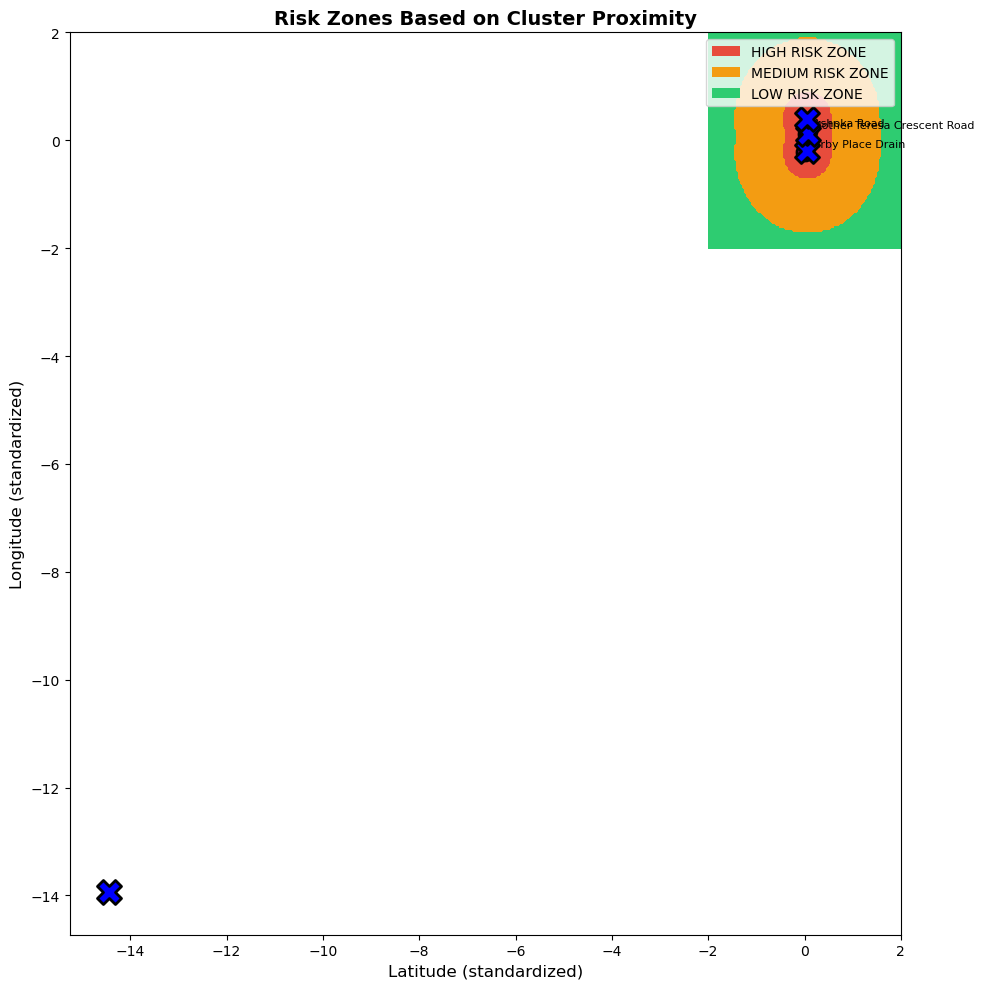

✓ Risk zones map saved as 'risk_zones_map.png'


In [13]:
# Visualize cluster locations and risk zones
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of points to visualize risk zones
lat_min, lat_max = -2, 2  # standardized coordinates
lon_min, lon_max = -2, 2

# Generate grid
lat_grid = np.linspace(lat_min, lat_max, 100)
lon_grid = np.linspace(lon_min, lon_max, 100)
lat_mesh, lon_mesh = np.meshgrid(lat_grid, lon_grid)

# Calculate risk zones for grid
risk_grid = np.zeros_like(lat_mesh)
for i in range(lat_mesh.shape[0]):
    for j in range(lat_mesh.shape[1]):
        coords_scaled = np.array([lat_mesh[i, j], lon_mesh[i, j]])
        distances = np.linalg.norm(centroids - coords_scaled, axis=1)
        min_dist = np.min(distances)
        
        if min_dist <= 0.5:
            risk_grid[i, j] = 2  # HIGH
        elif min_dist <= 1.5:
            risk_grid[i, j] = 1  # MEDIUM
        else:
            risk_grid[i, j] = 0  # LOW

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot risk zones (LOW=0, MEDIUM=1, HIGH=2)
im = ax.contourf(lat_mesh, lon_mesh, risk_grid, levels=[0, 0.5, 1.5, 2.5], 
                  colors=['#2ecc71', '#f39c12', '#e74c3c'])

# Plot cluster centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='blue', marker='X', s=300, 
          edgecolors='black', linewidth=2, label='Cluster Centroids', zorder=5)

# Plot test locations
for idx, (lat, lon, name) in enumerate(test_locations[:3]):
    coords_scaled = scaler.transform([[lat, lon]])[0]
    ax.scatter(coords_scaled[0], coords_scaled[1], c='purple', marker='o', s=150, 
              edgecolors='black', linewidth=2, zorder=4)
    ax.text(coords_scaled[0] + 0.1, coords_scaled[1] + 0.1, name, fontsize=8)

ax.set_xlabel('Latitude (standardized)', fontsize=12)
ax.set_ylabel('Longitude (standardized)', fontsize=12)
ax.set_title('Risk Zones Based on Cluster Proximity', fontsize=14, fontweight='bold')

# Custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='HIGH RISK ZONE'),
    Patch(facecolor='#f39c12', label='MEDIUM RISK ZONE'),
    Patch(facecolor='#2ecc71', label='LOW RISK ZONE'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('risk_zones_map.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Risk zones map saved as 'risk_zones_map.png'")

In [16]:
# Function to analyze a batch of coordinates
def analyze_risk_batch(coords_list):
    """
    Analyze risk zones for a batch of coordinates.
    
    Parameters:
    - coords_list: list of tuples (latitude, longitude) or (latitude, longitude, name)
    
    Returns:
    - DataFrame with results
    """
    results = []
    for item in coords_list:
        if len(item) == 3:
            lat, lon, name = item
        else:
            lat, lon = item
            name = f"({lat:.4f}, {lon:.4f})"
        
        risk_zone, cluster_id, distance = get_risk_zone(lat, lon)
        results.append({
            'Name': name,
            'Latitude': lat,
            'Longitude': lon,
            'Nearest_Cluster': cluster_id,
            'Distance': f"{distance:.4f}",
            'Risk_Zone': risk_zone
        })
    
    return pd.DataFrame(results)

print("===             Test             ===")
batch_coords = [
    (28.636, 77.228, "Connaught Place"),
    (28.5747, 77.1191, "Dwarka"),
    (28.6500, 77.2500, "Central Delhi"),
    (28.5500, 77.3000, "East Delhi"),
]

batch_results = analyze_risk_batch(batch_coords)
print(batch_results.to_string(index=False))

===             Test             ===
           Name  Latitude  Longitude  Nearest_Cluster Distance        Risk_Zone
Connaught Place   28.6360    77.2280                2   0.1079 MEDIUM RISK ZONE
         Dwarka   28.5747    77.1191                0   0.0551   HIGH RISK ZONE
  Central Delhi   28.6500    77.2500                3   0.0935 MEDIUM RISK ZONE
     East Delhi   28.5500    77.3000                3   0.1581    LOW RISK ZONE
